# Predicting Bike Rentals
In this project I use a Washington D.C. communal bike rental data.  This information was compiled by Hadi Fanaee-T at the University of  Porto. The dataset is originally published by **capital bikeshare** (CBS).
The original data included:

- **Duration** – Duration of trip
- **Start Date** – Includes start date and time
- **End Date** – Includes end date and time
- **Start Station** – Includes starting station name and number
- **End Station** – Includes ending station name and number
- **Bike Number** – Includes ID number of bike used for the trip
- **Member Type** – Indicates whether user was a "registered" member (Annual Member, 30-Day Member or Day Key Member) or a "casual" rider (Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass)

Hadi took this information as example for his demonstration for an _Event labeling combining ensemble detectors and backgroundknowledge_. For this, he added added weather and Holiday information to the dataset. The information is then **labeled** and organized in such a way that one row corresponds to a single hour of a single day. You can download the data  from the University of California, Irvine's [website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). The dataset contains the following information:

- **instant**: record index
- **dteday** : date
- **season** : season (1:winter, 2:spring, 3:summer, 4:fall)
- **yr** : year (0: 2011, 1:2012)
- **mnth** : month ( 1 to 12)
- **hr** : hour (0 to 23)
- **holiday** : weather day is holiday or not (extracted from [Department of Human Resources](http://dchr.dc.gov/page/holiday-schedule))
- **weekday** : day of the week
- **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0.
- **weathersit** :
    - **1**: Clear, Few clouds, Partly cloudy, Partly cloudy
    - **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- **atemp**: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- **hum**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered


The published paper is out of discussion in this project but if you are curious as I do, check this [pdf](Fanaee-T-Gama2014_Article_EventLabelingCombiningEnsemble.pdf). The goal of this project is to predict the total number of bikes people rented in a given hour. I'll use different machine learning algorithms and check their performance in terms of precision. When possible, I'll be using a fixed seed for random algorithms, which makes the test reproducible.

The precision will be evaluated by the mean squared error (MSE) that the algorithm presents, which measures the average of the squares of the errors. In simple words: it measures the average squared difference between the estimated values and the actual values. The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better. 

\begin{equation*}
\operatorname{MSE}=\frac{1}{n}\sum_{i=1}^n(\hat{Y_i} - Y_i)^2
\end{equation*}

## Project setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
plt.style.use('seaborn-poster')

## Dataset overview

In [3]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
df_rows = bike_rentals.shape[0]
df_cols = bike_rentals.shape[1]
print("The dataframe is composed of {} rows and {} columns".format(df_rows, df_cols))

The dataframe is composed of 17379 rows and 17 columns


In [4]:
print("First rows - transposed view")
bike_rentals.head(10).transpose()

First rows - transposed view


0           1           2           3           4  \
instant              1           2           3           4           5   
dteday      2011-01-01  2011-01-01  2011-01-01  2011-01-01  2011-01-01   
season               1           1           1           1           1   
yr                   0           0           0           0           0   
mnth                 1           1           1           1           1   
hr                   0           1           2           3           4   
holiday              0           0           0           0           0   
weekday              6           6           6           6           6   
workingday           0           0           0           0           0   
weathersit           1           1           1           1           1   
temp              0.24        0.22        0.22        0.24        0.24   
atemp           0.2879      0.2727      0.2727      0.2879      0.2879   
hum               0.81         0.8         0.8        0.75        0.75   
windspeed            0           0           0           0           0   
casual               3           8           5           3           0   
registered          13          32          27          10           1   
cnt                 16          40          32          13           1   

                     5           6           7           8           9  
instant              6           7           8           9          10  
dteday      2011-01-01  2011-01-01  2011-01-01  2011-01-01  2011-01-01  
season               1           1           1           1           1  
yr                   0           0           0           0           0  
mnth                 1           1           1           1           1  
hr                   5           6           7           8           9  
holiday              0           0           0           0           0  
weekday              6           6           6           6           6  
workingday           0           0           0           0           0  
weathersit           2           1           1           1           1  
temp              0.24        0.22         0.2        0.24        0.32  
atemp           0.2576      0.2727      0.2576      0.2879      0.3485  
hum               0.75         0.8        0.86        0.75        0.76  
windspeed       0.0896           0           0           0           0  
casual               0           2           1           1           8  
registered           1           0           2           7           6  
cnt                  1           2           3           8          14

Check for missing values:

In [5]:
bike_rentals.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

## Hourly rentals distribution
At a first glance, we will see what the distribution looks like.

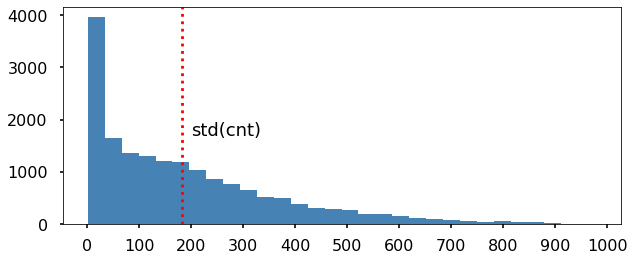

In [6]:
# Histogram plot
ax = bike_rentals['cnt'].hist(color='steelblue', figsize=(10,4), bins=30)

# Extra stuff
cnt_std = bike_rentals['cnt'].std()
ticks = np.linspace(0, 1000, 11, endpoint=True, dtype=int)
_ = ax.grid(False)
_ = ax.set_xticks(ticks)
_ = ax.axvline(cnt_std, ls='dotted', c='r')
_ = ax.text(x=cnt_std*1.1, y=1700, s='std(cnt)', size=18)


## Features correlation with hourly rentals

We analyze the features correlation with respect to 'cnt':

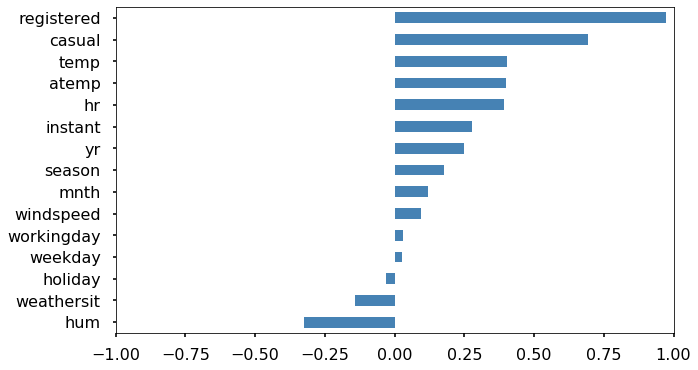

In [8]:
bike_rentals.corr()['cnt'].sort_values()[:-1].plot.barh(color='steelblue', figsize=(10,6))
_ = plt.xlim(-1,1)

The 'hr' column has good correlation with the hourly rentals count ('cnt'). For this analysis, we would have a better point of view if we split this information in 'morning', 'afternoon', 'evening' and 'night'. Since I will use machine learning, it is better to assign numbers to each day slot. I'll be using 1 up to 4.

In [15]:
def assign_label(hr):
    day_slot = 0
    if hr >= 6 and hr < 12:
        day_slot = 1
    elif hr >= 12 and hr < 18:
        day_slot = 2
    elif hr >= 18 and hr <= 24:
        day_slot = 3
    elif hr >= 0 and hr < 6:
        day_slot = 4
    
    return day_slot

In [17]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
print("Group hours with labels")
bike_rentals[['hr', 'time_label']].sample(10)

Group hours with labels


hr  time_label
12393  14           2
8087   15           2
9861   21           3
3298    8           1
7669    4           4
12923  16           2
348     0           4
5100   10           1
9804   11           1
3009    7           1

## ML-Models evaluation criteria
I'll be using the **MSE** metric to check the models in this project. This error metric is useful for this case since we have a target which is numerical and continuous.

## Train and test data sets
I'll be using 80% of the available data as the training set and 20% for testing.

In [24]:
train = bike_rentals.sample(frac=0.8, random_state=5)
train_selection = bike_rentals.index.isin(train.index)

test = bike_rentals[~train_selection]

In [25]:
print('{} rows for train and {} rows for test sets'.format(train.shape[0], test.shape[0]))

13903 rows for train and 3476 rows for test sets


## Filtering only useful features

In [26]:
features = bike_rentals.columns
# Drop non-useful features
features = features.drop(['cnt', 'casual', 'registered', 'dteday'])
print(features.values)

['instant' 'season' 'yr' 'mnth' 'hr' 'holiday' 'weekday' 'workingday'
 'weathersit' 'temp' 'atemp' 'hum' 'windspeed' 'time_label']


In [27]:
# Check correlations
correlations = bike_rentals.corr()['cnt'][features].sort_values(ascending=False)
correlations


temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

**temp** and **atemp** have almost the same information but I decided to drop 'temp'.  The reason is that apparent temperature ('atemp') is an index. I think this index is better because combines temperature with wind and/or humidity information. ([more info here](https://meteor.geol.iastate.edu/~ckarsten/bufkit/apparent_temperature.html)).

In [28]:
features = features.drop('temp')

We can simplify the features to a smaller list. I'm thinking about giving a threshold of 0.25 to the correlations (positive and  negative). If the correlation is lower than the threshold, then this feature is removed. I'll keep the feature otherwise. The following features have the highest correlations:

In [29]:
sel_pos = correlations > 0.25 
sel_neg = correlations <-0.25 
sel_strict = sel_neg | sel_pos

correlations_strict = correlations.loc[sel_strict]
correlations_strict

temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

We can see this clearly in a plot:

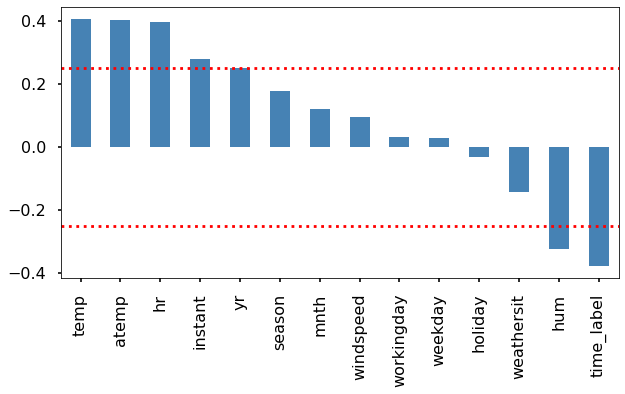

In [30]:
threshold = 0.25
ax = correlations.plot.bar(color='steelblue', figsize=(10,5))
ax.axhline(threshold, c='r', ls='dotted')
ax.axhline(-threshold, c='r', ls='dotted')

Let's save the results as '*features*' (13 features) and '*features_strict*' (6 features):


In [34]:
to_drop = correlations.loc[~sel_strict].index.values
features_strict = features.drop(to_drop)

print("Features:", features.values)
print("Strict Features:", features_strict.values)

Features: ['instant' 'season' 'yr' 'mnth' 'hr' 'holiday' 'weekday' 'workingday'
 'weathersit' 'atemp' 'hum' 'windspeed' 'time_label']
Strict Features: ['instant' 'yr' 'hr' 'atemp' 'hum' 'time_label']


## Linear regression model

In [35]:
# Test with selected Features
lr = LinearRegression()
lr.fit(train[features], train['cnt'])
lr_predictions = lr.predict(test[features])

lr_mse = mean_squared_error(test['cnt'], lr_predictions)
print(lr_mse)

16850.05763141022


In [36]:
# Test with Strict Features, those with more than 0.25 correlation
lr.fit(train[features_strict], train['cnt'])
lr_predictions = lr.predict(test[features_strict])

lr_mse = mean_squared_error(test['cnt'], lr_predictions)
print(lr_mse)

17027.471019462733


### Verdict
The MSE value for a linear regression model is high. The test with strict features shows that there is no much improvement with all selected features and the features list can be simplified.

## Decision Tree model
For the decision tree model, I'll search for the best 'min_samples_leaf' parameter (for more information see [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)).

In [37]:
# Test with selected Features
dt = DecisionTreeRegressor(random_state=0)
dt.fit(train[features], train['cnt'])
dt_predictions = dt.predict(test[features])

dt_mse = mean_squared_error(test['cnt'], dt_predictions)
print(dt_mse)

3293.631760644419


In [38]:
# Test with different values for 'min_samples_leaf'
dt_mse_values = []
for m in range(1, 31):
    dt = DecisionTreeRegressor(min_samples_leaf=m, random_state=0)
    dt.fit(train[features], train['cnt'])
    dt_predictions = dt.predict(test[features])

    dt_mse = mean_squared_error(test['cnt'], dt_predictions)
    dt_mse_values.append(dt_mse)

mse_min:  2426.3069360588975


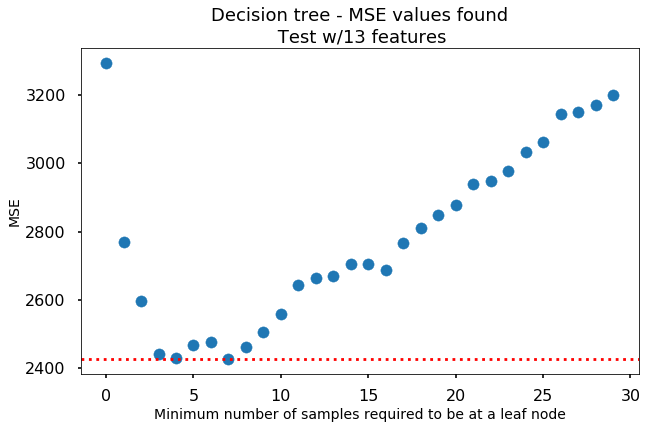

In [39]:
m = min(dt_mse_values)
dt_mse_min = dt_mse_values[dt_mse_values.index(m)]
print('mse_min: ', dt_mse_min)

plt.figure(figsize=(10,6))
plt.scatter(range(30), dt_mse_values)
plt.axhline(dt_mse_min, c='r', ls='dotted')
plt.xlabel('Minimum number of samples required to be at a leaf node', size=14)
plt.ylabel('MSE', size=14)
_ = plt.title('Decision tree - MSE values found\n Test w/13 features', size=18)

Now let's repeat the test but with the strict features set:

In [40]:
# Same test but with strict features, those with more than 0.25 correlation
dt_mse_values_strict = []
for m in range(1, 31):
    dt = DecisionTreeRegressor(min_samples_leaf=m, random_state=0)
    dt.fit(train[features_strict], train['cnt'])
    dt_predictions = dt.predict(test[features_strict])

    dt_mse = mean_squared_error(test['cnt'], dt_predictions)
    dt_mse_values_strict.append(dt_mse)

mse_min:  7456.073078980593


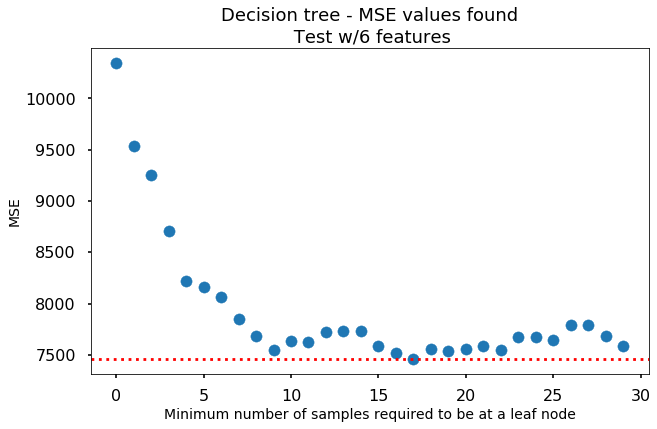

In [41]:
m = min(dt_mse_values_strict)
dt_mse_min_strict = dt_mse_values_strict[dt_mse_values_strict.index(m)]
print('mse_min: ', dt_mse_min_strict)

plt.figure(figsize=(10,6))
plt.scatter(range(30), dt_mse_values_strict)
plt.axhline(dt_mse_min_strict, c='r', ls='dotted')
plt.xlabel('Minimum number of samples required to be at a leaf node', size=14)
plt.ylabel('MSE', size=14)
_ = plt.title('Decision tree - MSE values found\n Test w/6 features', size=18)

We observed that the MSE increased significantly when using only 6 features instead of 13.

Now let's try with a fixed min_samples_leaf and different values for min_samples_split:

In [44]:
# Test with 'min_samples_leaf'=4 and different values for min_samples_split
dt_mse_values_opt = []
for m in range(2, 31):
    dt = DecisionTreeRegressor(min_samples_leaf=4, min_samples_split=m, random_state=0)
    dt.fit(train[features], train['cnt'])
    dt_predictions = dt.predict(test[features])

    dt_mse = mean_squared_error(test['cnt'], dt_predictions)
    dt_mse_values_opt.append(dt_mse)

mse_min:  2392.7461946701906


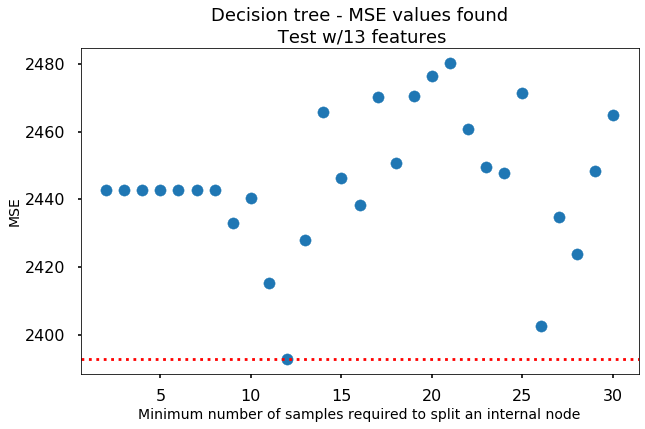

In [45]:
m = min(dt_mse_values_opt)
dt_mse_min_opt = dt_mse_values_opt[dt_mse_values_opt.index(m)]
print('mse_min: ', dt_mse_min_opt)

plt.figure(figsize=(10,6))
plt.scatter(range(2,31), dt_mse_values_opt)
plt.axhline(dt_mse_min_opt, c='r', ls='dotted')
plt.xlabel('Minimum number of samples required to split an internal node', size=14)
plt.ylabel('MSE', size=14)
_ = plt.title('Decision tree - MSE values found\n Test w/13 features', size=18)

### Verdict
The **decision tree** is an improvement with respect to the **linear regression** model. It lowered the MSE value from 16850 to 3293 (with default parameters). We can see however that the parameter **min_samples_leaf** is of big importance. With a optimum value of 4, the MSE reach a floor of 2426 but with different values showed that the MSE increases. A value of 7 is also valid but the smaller, the better.

On the other side, I tested the same process with a strict list of features. These have more than 0.25 correlation with target. In this case, the MSE by an approximated factor of 3!

An improvement is obtained after changing the parameter 'min_samples_split' from 2 to 31. With 2 being the default value. In this case, the MSE is reduced from 2426 to 2392. This is valid if the value of min_samples_leaf is kept to 4.

## Random Forest model

In [46]:
# Test with selected Features
rf = RandomForestRegressor(n_estimators=10, random_state=0)
rf.fit(train[features], train['cnt'])
rf_predictions = rf.predict(test[features])

rf_mse = mean_squared_error(test['cnt'], rf_predictions)
print(rf_mse)

1814.3373762945914


With defaults parameters, we obtained a MSE of 1814. Let's explore some values for the number of estimators in this forest:

In [47]:
# Test with different values for n_estimators
rf_mse_values = []
x_points = np.logspace(1, 2.5, 30, dtype=int)
for m in x_points:
    rf = RandomForestRegressor(n_estimators=m, random_state=0)
    rf.fit(train[features], train['cnt'])
    rf_predictions = rf.predict(test[features])

    rf_mse = mean_squared_error(test['cnt'], rf_predictions)
    rf_mse_values.append(rf_mse)

In [ ]:
m = min(rf_mse_values)
rf_mse_min = rf_mse_values[rf_mse_values.index(m)]
print('mse_min: ', rf_mse_min)

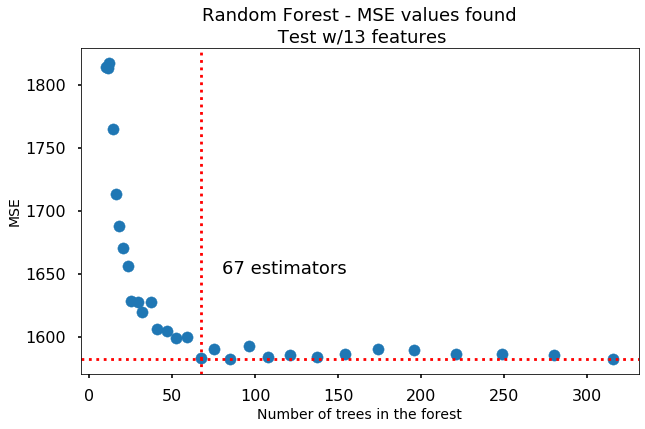

In [56]:
plt.figure(figsize=(10,6))
plt.scatter(x_points, rf_mse_values)
plt.axhline(rf_mse_min, c='r', ls='dotted')
plt.axvline(67, c='r', ls='dotted')
plt.text(x=80,y=1650, s="67 estimators", size=18)
plt.xlabel('Number of trees in the forest', size=14)
plt.ylabel('MSE', size=14)
_ = plt.title('Random Forest - MSE values found\n Test w/13 features', size=18)

We can see that this model could be implemented with 67 estimators (trees) and there is no need to increment this parameter. The MSE value was decreased to 1582.

The next step will be to test the algorithm with the strict set of features:

In [57]:
# Test with different values for n_estimators and only strict features
rf_mse_values_strict = []
x_points = np.logspace(1, 2.5, 30, dtype=int)
for m in x_points:
    rf = RandomForestRegressor(n_estimators=m, random_state=0)
    rf.fit(train[features_strict], train['cnt'])
    rf_predictions = rf.predict(test[features_strict])

    rf_mse = mean_squared_error(test['cnt'], rf_predictions)
    rf_mse_values_strict.append(rf_mse)

In [59]:
m = min(rf_mse_values_strict)
rf_mse_min_strict = rf_mse_values_strict[rf_mse_values_strict.index(m)]
print('mse_min: ', rf_mse_min_strict)

mse_min:  6093.505978266731


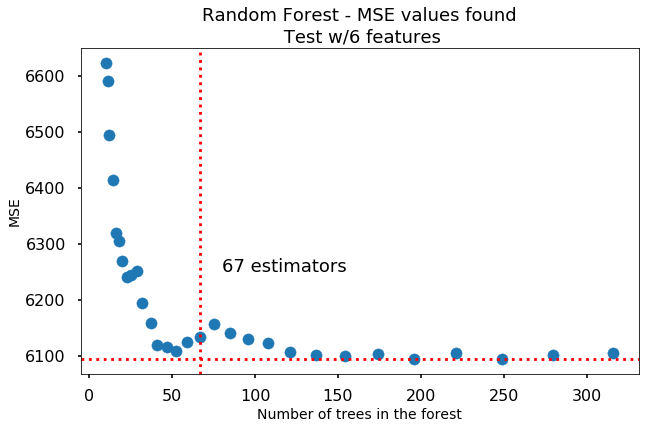

In [77]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

ax.scatter(x_points, rf_mse_values_strict)
plt.xlabel('Number of trees in the forest', size=14)

ax.axhline(rf_mse_min_strict, c='r', ls='dotted')
ax.axvline(67, c='r', ls='dotted')
plt.text(x=80,y=6250, s="67 estimators", size=18)

plt.ylabel('MSE', size=14)
_ = plt.title('Random Forest - MSE values found\n Test w/6 features', size=18)

In this case, we see that the strict list of features increases the MSE values by a factor of at least 4. Remember that these features had more than 0.25 correlation with the target.

Let's make a last test. Including the information we obtained in the decision tree model (min_sample_leaf=4) and using all the features:

In [78]:
# Test with different values for n_estimators while keeping min_samples_leaf=4
rf_mse_values_opt = []

for m in x_points:
    rf = RandomForestRegressor(n_estimators=m, min_samples_leaf=4, random_state=0)
    rf.fit(train[features], train['cnt'])
    rf_predictions = rf.predict(test[features])

    rf_mse = mean_squared_error(test['cnt'], rf_predictions)
    rf_mse_values_opt.append(rf_mse)

In [79]:
m = min(rf_mse_values_opt)
rf_mse_min_opt = rf_mse_values_opt[rf_mse_values_opt.index(m)]
print('mse_min: ', rf_mse_min_opt)

mse_min:  1660.7502312849244


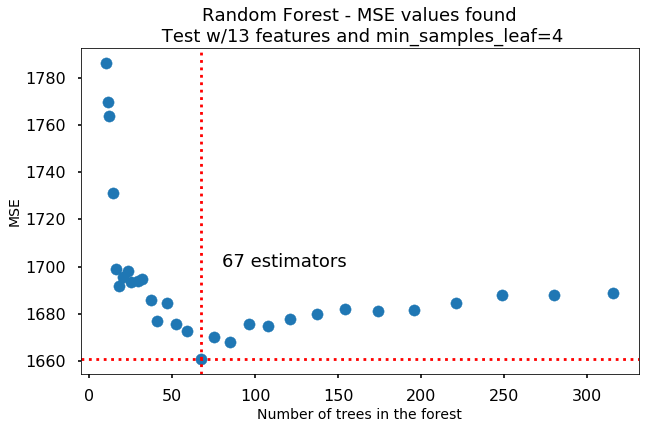

In [83]:
plt.figure(figsize=(10,6))
plt.scatter(x_points, rf_mse_values_opt)
plt.axhline(rf_mse_min_opt, c='r', ls='dotted')
plt.axvline(67, c='r', ls='dotted')
plt.text(x=80,y=1700, s="67 estimators", size=18)

plt.xlabel('Number of trees in the forest', size=14)
plt.ylabel('MSE', size=14)
_ = plt.title('Random Forest - MSE values found\n Test w/13 features and min_samples_leaf=4', size=18)

We can see that there is no improvement with keeping min_samples_leaf to 4, which is the best value we found in the decision tree model.

### Verdict
We found that a random forest decreases, as expected, the MSE value with respect to the decision tree. It decreased to 1814. The number of estimators is 10 by default in *sklearn* version '0.21.3'. This may be the main reason why the MES is significantly reduced.

With this logic, an increase in number of estimators will reduce even more the MSE. Actually from version '0.22' this parameter is 100 by default.  In our case, however, we found that we had a good result with 67 estimators (MSE=1582). There is no significant improvement by increasing it even more. There may be even worst results, depending on which value we choose (see the respective figure).

Finally I took the optimal decision tree model value for the parameter **min_samples_leaf**. This test showed that this approach is not optimal for the whole random forest. The minimum MSE found increased to 1660 compared to 1582. Think that all the trees will have the same setup and may limit the potential a random forest has. Then, I decided to keep this parameter to the default value (=1). Take a look to the plot in which I used a fixed *min_samples_leaf*. We can observe that this is optimal with a value of 4. The figure shows that the MSE has some volatility around this value.


## Conclusion
We checked 3 ML models to predict the number of bikes rented in a given hour for a given day. From the distribution in the count column ('cnt') we see that most of the counts are less than 200 bikes an hour. 

The first step was to identify the correlations between features and target. Some were not useful and we dropped them. We keep a *features* list and a *strict features* list. The strict list is with those features that have more than 0.25 correlation with the target.

The second step was to split the data in train and test sets. We used 80% for the train and 20% for the test.

### Models performance
We observed that the 3 models behave differently. We started with an MSE around 17000 and ended with a value about 1600. Remember that the metric is a squared value. This means that when we measure the bike rentals count per hour, we will have an error about 130 bikes in the worst case (MSE=17000) and 40 bikes in the best case (MSE=1600). **This error could be too high depending on the scenario in which the prediction is used**.
#### Linear Regression - MSE = 16850 to 17027
The first model we saw is a **linear regression model**. This bring the MSE value to **16850** with all the selected features. When comparing the results with the strict list of features, there is no much difference in MSE (**17027**). On one side, we conclude that we can use the reduced list. On the other side, the model is useless since the error is too high compared to the data distribution.

#### Decision Tree - MSE = 2406 to 3293
The second model is a **decision tree**. With this model we obtained an MSE of **3293** with default values. When changing the parameter *min_samples_leaf* we observed that a significant improvement is achieved. The MSE is reduced to **2426** when setting this parameter to 4.
This model showed us that the strict list of features wasn't useful this time. The MSE value incremented about 3 times. 
We could improve the model even more with the parameter *min_samples_split*. With a value of 12, the MSE decreased to **2406**. This is however an special case, since if we change its value, the MSE will be above approximately **2430**.

#### Random Forest - MSE = 1582 to 1814
The third model is the **random forest**. With default parameters, an MSE dropped to **1814**. When we changed the number of trees (estimators) in the forest, MSE dropped even more. The optimal **quantity of estimators** was **67**, where MSE is **1582**.
When testing with the strict list of features, the same behavior as the decision tree happen. The MSE increased heavily.
We check a last test using the *decision tree* model information. The optimal value for the parameter 'min_samples_leaf'. This showed us that the approach is not good and the MSE values increased. We can thing that we are setting all the trees to the same structure. This may restrict the potential a random forest has, increasing the MSE values.